In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

IMG_HEIGHT = 150
IMG_WIDTH = 150

BATCH_SIZE = 32

TRAIN_DIR = '../processed_data/dataset_1_split/train'
VALIDATION_DIR = '../processed_data/dataset_1_split/validation'


print("Configurando o gerador de dados de TREINO...")
train_datagen = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=40,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True,       
    fill_mode='nearest'         
)

print("Configurando o gerador de dados de VALIDAÇÃO...")
validation_datagen = ImageDataGenerator(
    rescale=1./255
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True               
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False              
)

class_names = list(validation_generator.class_indices.keys())

2025-06-16 20:20:35.354295: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 20:20:35.359876: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 20:20:35.374136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750116035.395394  177896 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750116035.406113  177896 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750116035.425715  177896 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Configurando o gerador de dados de TREINO...
Configurando o gerador de dados de VALIDAÇÃO...
Found 1600 images belonging to 16 classes.
Found 411 images belonging to 16 classes.


/home/adame/Desktop/projeto_final_pdi_correto/cnn_food/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 627ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 724ms/step
Encontrado(s) 11 exemplo(s) de imagens que o modelo otimizado corrigiu!


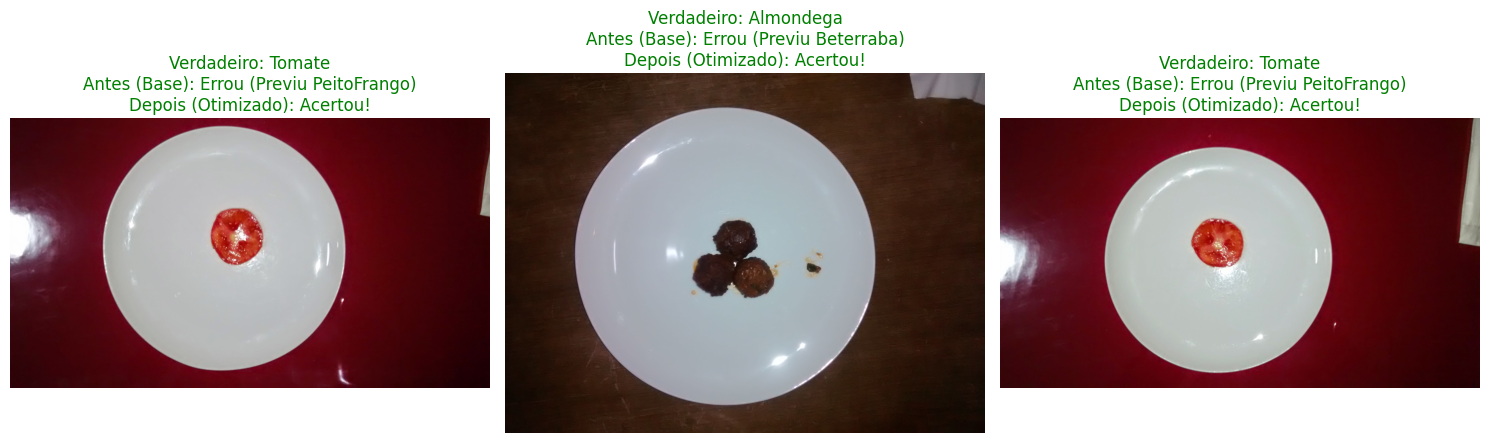

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# --- CONFIGURAÇÃO ---
# Carrega os dois modelos que você salvou
model_base = tf.keras.models.load_model('modelo_base.h5')
model_otimizado = tf.keras.models.load_model('modelo_otimizado.h5') # Use o nome do seu melhor modelo

# Use o mesmo gerador de validação que você já tem
# Certifique-se de que o shuffle está como False para que as labels correspondam aos arquivos
validation_generator.reset() # Garante que o gerador comece do início

# Pega os nomes das classes
class_names = list(validation_generator.class_indices.keys())

# --- LÓGICA PARA ENCONTRAR MELHORIAS ---

# Faz previsões com os dois modelos
pred_base = model_base.predict(validation_generator)
pred_otimizado = model_otimizado.predict(validation_generator)

# Converte probabilidades para a classe prevista (índice)
y_pred_base = np.argmax(pred_base, axis=1)
y_pred_otimizado = np.argmax(pred_otimizado, axis=1)

# Pega as classes verdadeiras
y_true = validation_generator.classes

# Encontra os índices das imagens que foram corrigidas
indices_corrigidos = []
for i in range(len(y_true)):
    if y_pred_base[i] != y_true[i] and y_pred_otimizado[i] == y_true[i]:
        indices_corrigidos.append(i)

print(f"Encontrado(s) {len(indices_corrigidos)} exemplo(s) de imagens que o modelo otimizado corrigiu!")

# --- VISUALIZAÇÃO DOS RESULTADOS ---

# Mostra alguns exemplos aleatórios de imagens corrigidas
if indices_corrigidos:
    plt.figure(figsize=(15, 5 * min(3, len(indices_corrigidos)))) # Mostra no máximo 3 exemplos
    
    # Pega até 3 exemplos aleatórios da lista de corrigidos
    exemplos_a_mostrar = random.sample(indices_corrigidos, k=min(3, len(indices_corrigidos)))

    for i, idx in enumerate(exemplos_a_mostrar):
        plt.subplot(1, 3, i + 1)
        
        # Carrega e exibe a imagem original
        img = tf.keras.utils.load_img(validation_generator.filepaths[idx])
        plt.imshow(img)
        plt.axis('off')

        # Cria o título da imagem
        true_label = class_names[y_true[idx]]
        base_pred_label = class_names[y_pred_base[idx]]
        
        title = f"Verdadeiro: {true_label}\n" \
                f"Antes (Base): Errou (Previu {base_pred_label})\n" \
                f"Depois (Otimizado): Acertou!"
        plt.title(title, color='green')
        
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum exemplo encontrado para esta execução. Tente treinar novamente ou seu modelo base já era muito bom!")

Modelo carregado com sucesso!
Visualizando ativações para a imagem: ../processed_data/dataset_1_split/validation/Alface/IMG_20140922_135146721.jpg (Classe: Alface)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


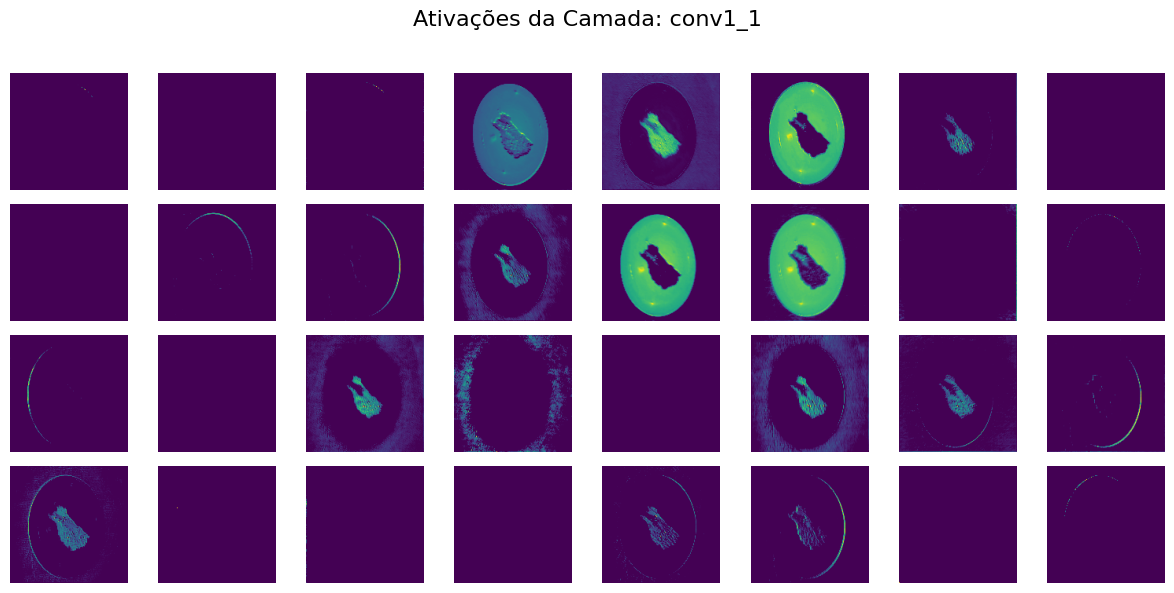

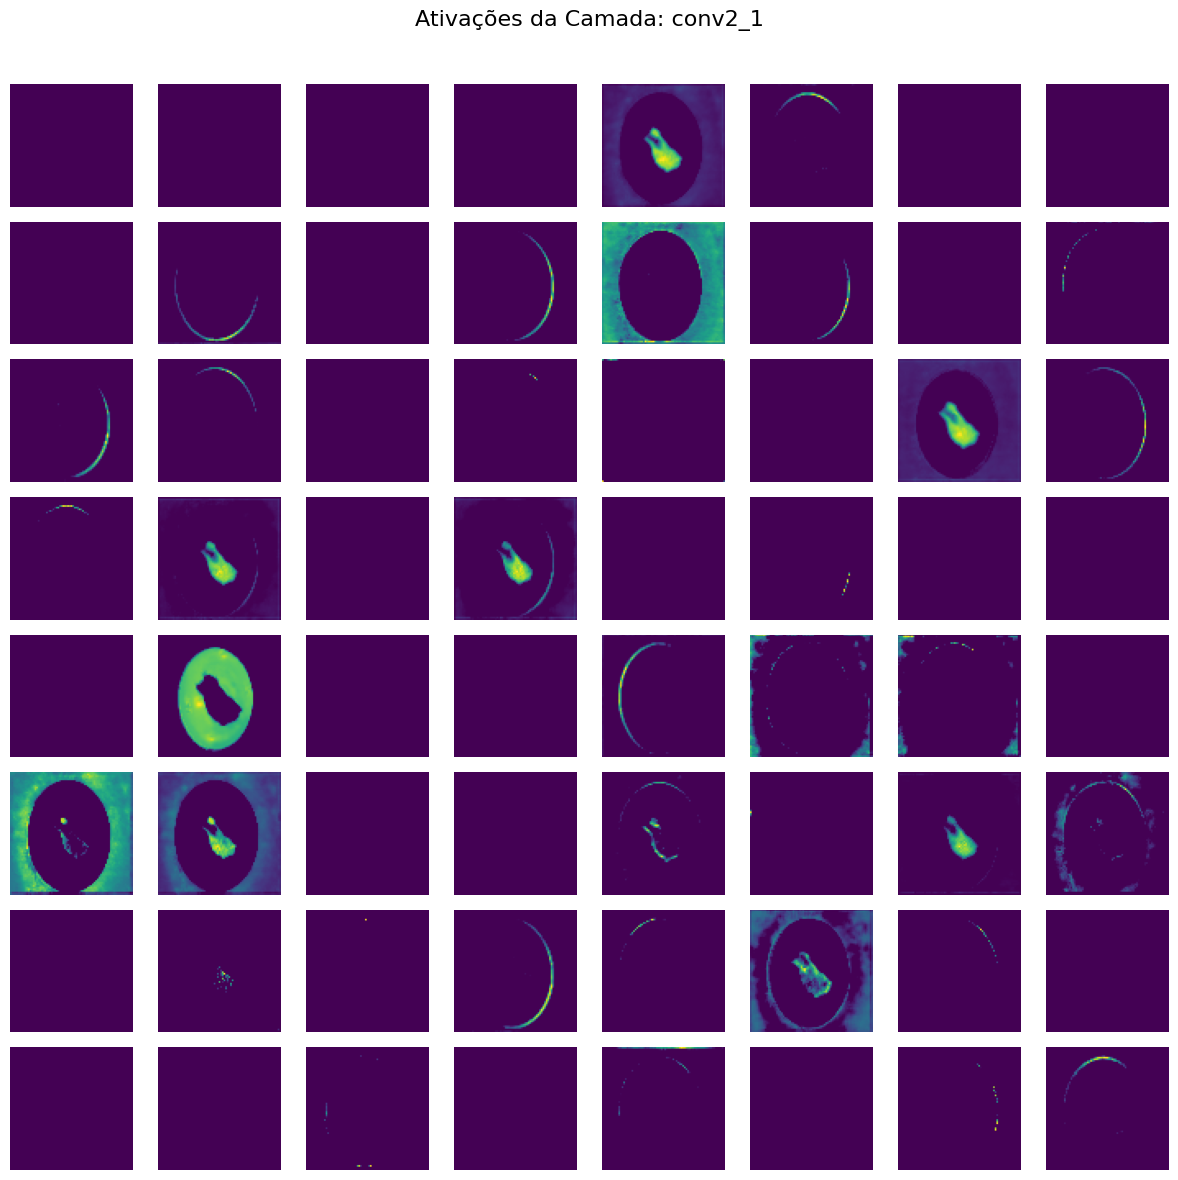

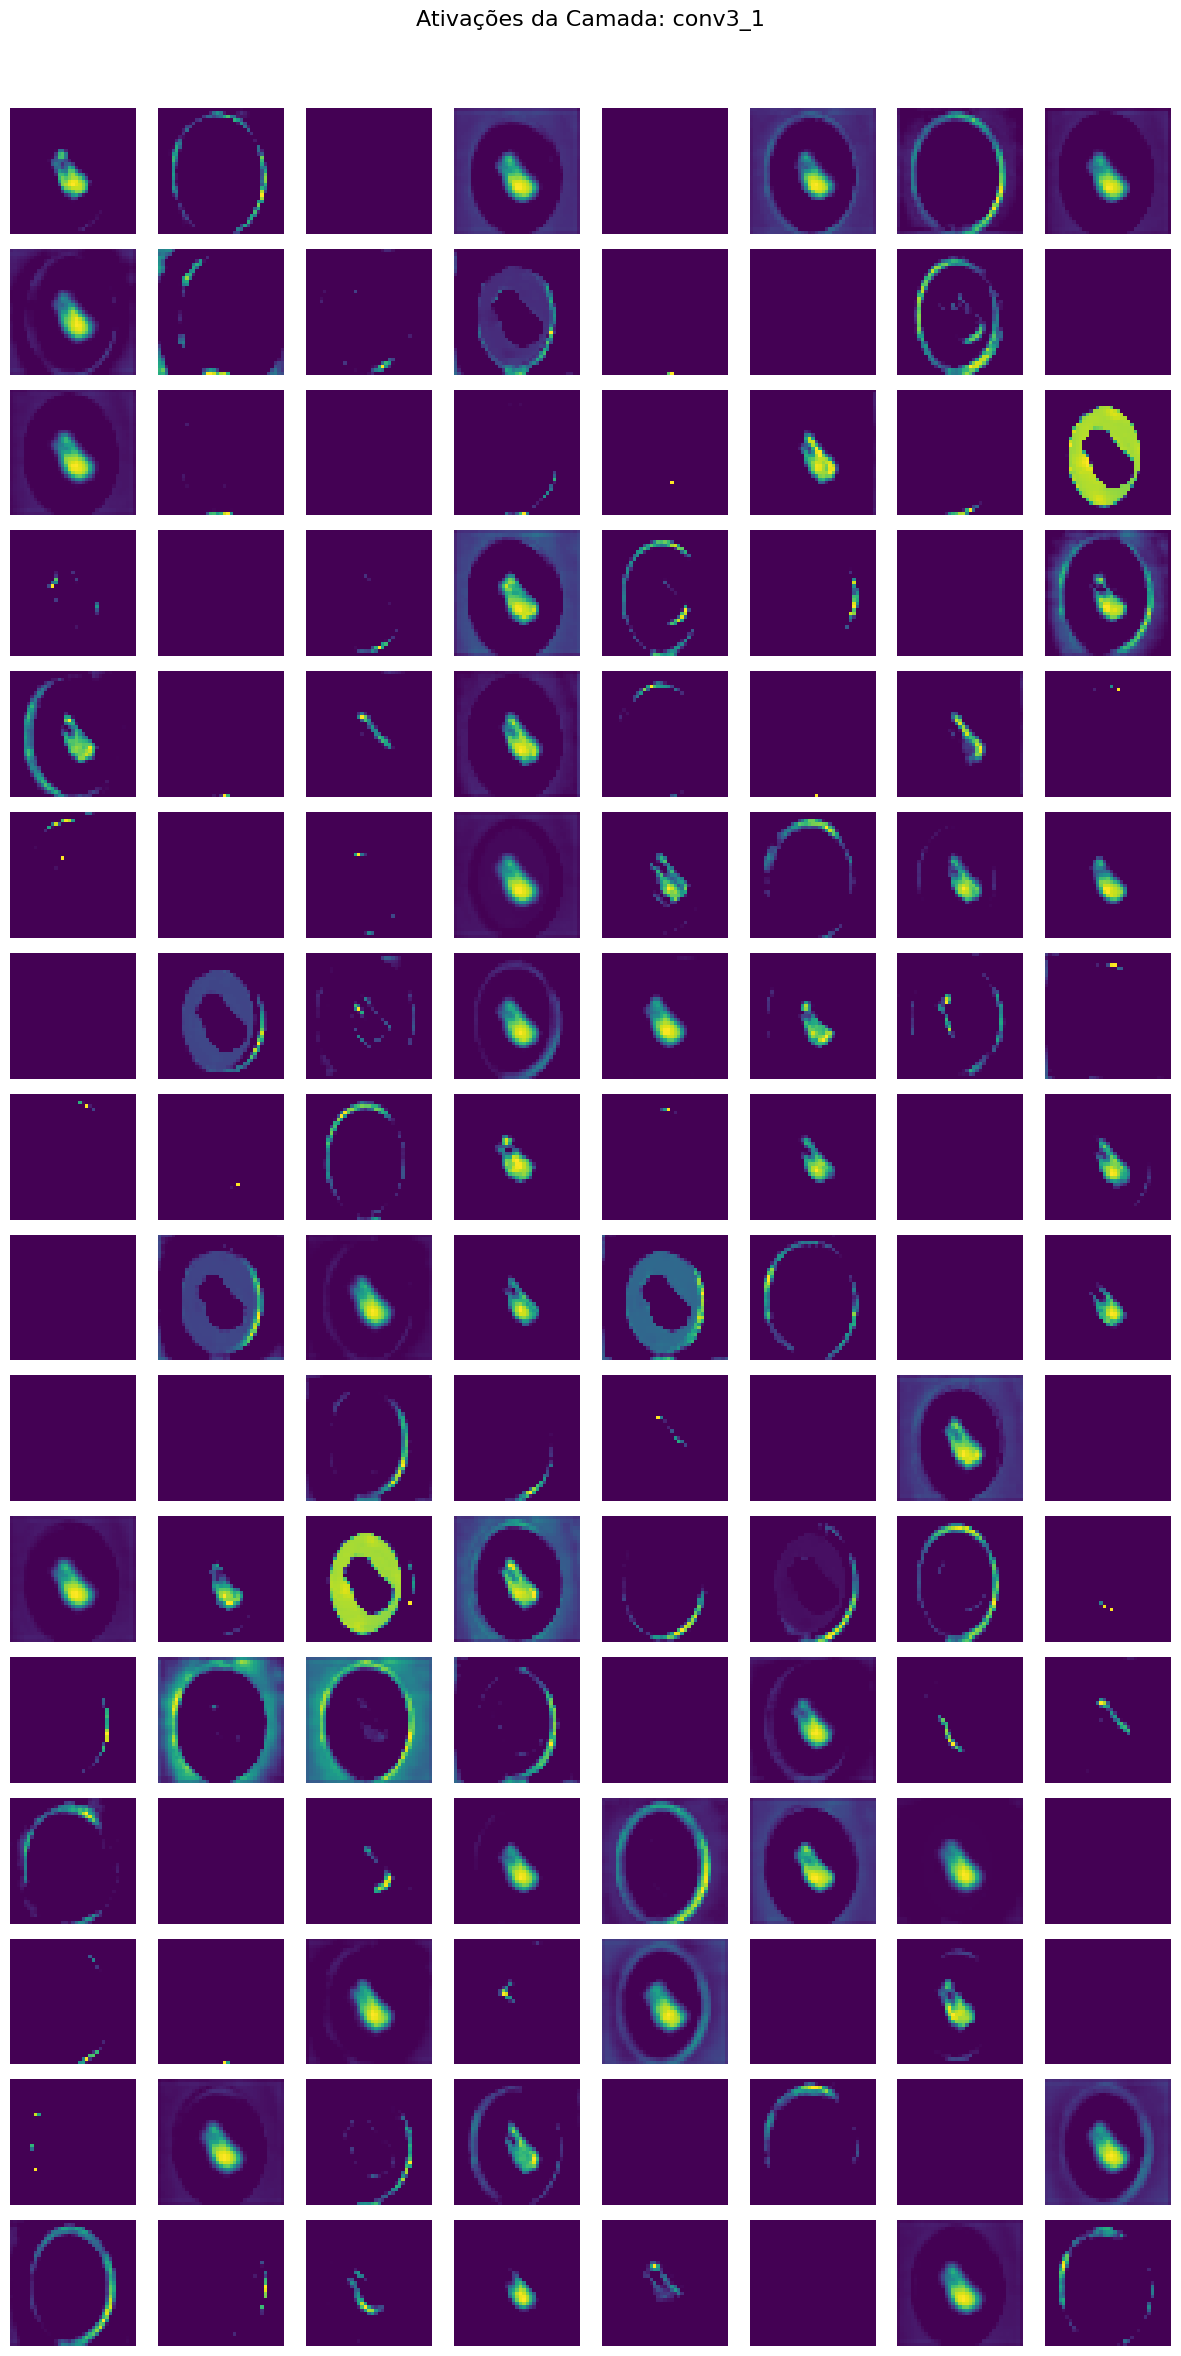

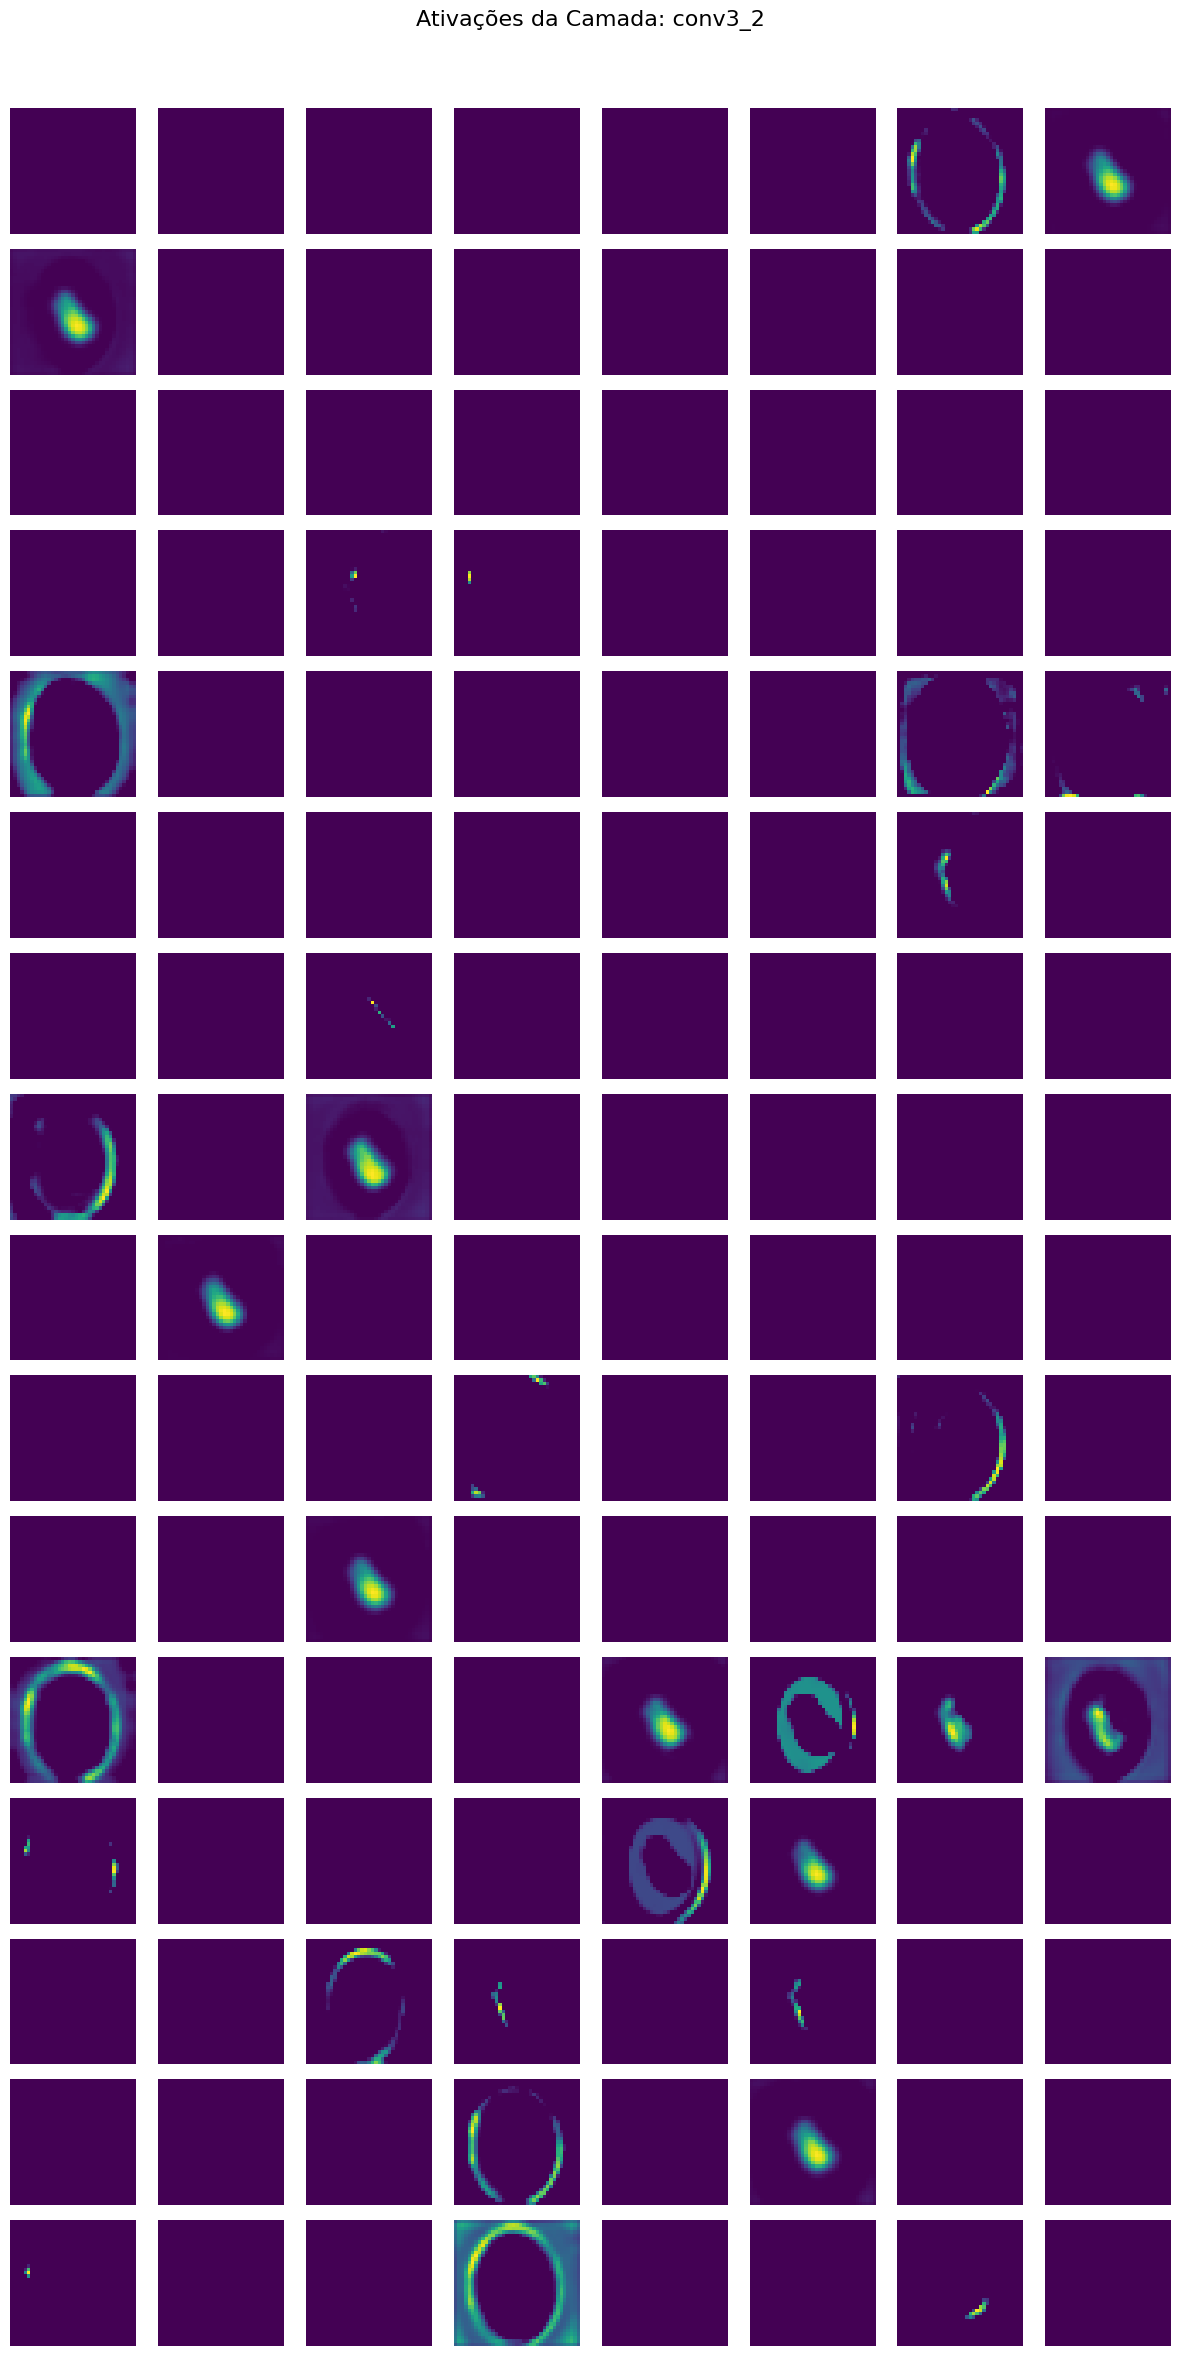

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

try:
    model = tf.keras.models.load_model('modelo_otimizado.h5')
    print("Modelo carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    model = None

if model:
    img_path = validation_generator.filepaths[0]
    true_label_name = class_names[validation_generator.classes[0]]
    print(f"Visualizando ativações para a imagem: {img_path} (Classe: {true_label_name})")

    # Pré-processa a imagem para alimentar o modelo
    img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
    img_tensor = tf.keras.utils.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    # Extrai as saídas das camadas que queremos visualizar
    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]

    # Cria um novo modelo que retorna as ativações dessas camadas
    visualization_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

    # Obtém as ativações ao passar a imagem pelo modelo
    activations = visualization_model.predict(img_tensor)

    # --- VISUALIZAÇÃO DAS ATIVAÇÕES ---

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        
        n_cols = 8
        n_rows = n_features // n_cols if n_features > 0 else 0
        
        if n_rows > 0:
            plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
            plt.suptitle(f'Ativações da Camada: {layer_name}', fontsize=16)

            for i in range(n_features):
                plt.subplot(n_rows, n_cols, i + 1)
                plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
                plt.axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()